+ Maybe with samaller samples adding on every iteration CEAL helps more

In [77]:
import pandas as pd
import os
import sys
module_path = "../src"
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
from pytorch_lightning import Trainer

# 2. DataModule & Class Libraries
from utils.ModelPrediction import get_prediction,get_probs,run_metrics
from utils.calc_stat import calc_dataset_mean_std
from utils.ActiveLearning import get_confidence_samples,get_uncertain_samples,calc_uncertainty
from utils.FeatureExtractor import evaluate_projection
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset, EvalImageDataset
from models.ResNetClass import ResNetClass
from utils.label_encoder import label_encoder_target
# 3. Pytorch & Pytorch Lightning Libraries
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
# 4. Wandb Tracker Exp

In [78]:
def get_train_transf(mean,std):
    return  transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize((256, 256)),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(15),
                        transforms.CenterCrop((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean,std)
                    ])
def get_valid_transf(mean,std):

    return  transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean,std)
                    ])

In [79]:
BASE_IMG_DIR    = Path('/mnt/')
SEED            = 42
num_classes     = 6
CRITERIA        = 'en'     
CEAL            = True
SAMPLES         = 1000
DELTA           = 0.05
DELTA_RATIO     = 0.0033
MAXIMUM_INTERATIONS = 10
#MAXIMUM_INTERATIONS = int(10000/SAMPLES)
BATCH_SIZE      = 32
NUM_WORKERS     = 32
MAX_EPOCHS      = 100
LEARNING_RATE   = 0.00001
FLG_RESET       = 0
METRIC_MONITOR  = "val_avg_loss"
MODE_METRIC     = 'min'
RESNET_MODEL    = 'resnet50'
DEVICE          = 'cuda'
CLASSIFIER      = 'higher_modality'
if CEAL:
    NAME_EXPERIMENT = f'Experiment_{CRITERIA}_CEAL_{str(CEAL)}_{RESNET_MODEL}_class_weights_{str(True)}_DELTA_{DELTA}'
else:
    NAME_EXPERIMENT = f'Experiment_{CRITERIA}_CEAL_{str(CEAL)}_{RESNET_MODEL}_class_weights_{str(True)}'
SAVE_AL_DATA    = os.path.join('../data/ActiveLearning',CLASSIFIER,str(SAMPLES),str(LEARNING_RATE),NAME_EXPERIMENT)
OUTPUT_DIR      = os.path.join('/mnt/artifacts/active_learning',CLASSIFIER,NAME_EXPERIMENT)
os.makedirs(SAVE_AL_DATA,exist_ok=True)
os.makedirs(OUTPUT_DIR,exist_ok=True)
# Save in a yaml file
yaml_file = {
   'SEED'         : SEED,
    'CRITERIA'    : CRITERIA,
    'SAMPLES'     : SAMPLES,
    'CEAL'        : str(CEAL),
    'DELTA'       : DELTA,
    'DELTA_RATIO' : DELTA_RATIO,
    'MAXIMUM_INTERATIONS':MAXIMUM_INTERATIONS,
    'BATCH_SIZE'  : BATCH_SIZE,
    'MAX_EPOCHS'  : MAX_EPOCHS,
    'LEARNING_RATE' : LEARNING_RATE,
    'FLG_RESET_MODEL'  : FLG_RESET,
    'MODEL'       : RESNET_MODEL,
    'CLASSIFIER'  : CLASSIFIER
}

with open(os.path.join(SAVE_AL_DATA ,'training.yml'), 'w') as outfile:
    yaml.dump(yaml_file, outfile, default_flow_style=False)


In [80]:
!rm -Rf $OUTPUT_DIR

### 1. Divide Uniformly the Dataset
+ Split the dataset in 3 parts: Train (60%),Valid(20%), Test (20%)

In [81]:
'''
df_higher_modality     = pd.read_csv('../data/higher_modality_vol1.csv',sep = '\t').drop(columns = ['caption','split_set'])
df_higher_modality['split_set'] = 'TRAIN'
mskf = MultilabelStratifiedKFold(n_splits = 10,shuffle = True,random_state=SEED)
for fold,(train_index, test_index) in enumerate(mskf.split(df_higher_modality, df_higher_modality[['source','higher_modality']])):
    if (fold == 0)|(fold == 1):   
        df_higher_modality.loc[test_index,'split_set'] = 'TEST'
    elif (fold == 2):   
        df_higher_modality.loc[test_index,'split_set']   = 'VAL'
    else:
        df_higher_modality.loc[test_index,'split_set']   = 'TRAIN'
df_higher_modality.to_csv('../data/higher_modality_active_learning.csv',sep = '\t',index = False)
print(df_higher_modality[df_higher_modality['split_set']=='TRAIN'].shape)
del df_higher_modality 
'''

"\ndf_higher_modality     = pd.read_csv('../data/higher_modality_vol1.csv',sep = '\t').drop(columns = ['caption','split_set'])\ndf_higher_modality['split_set'] = 'TRAIN'\nmskf = MultilabelStratifiedKFold(n_splits = 10,shuffle = True,random_state=SEED)\nfor fold,(train_index, test_index) in enumerate(mskf.split(df_higher_modality, df_higher_modality[['source','higher_modality']])):\n    if (fold == 0)|(fold == 1):   \n        df_higher_modality.loc[test_index,'split_set'] = 'TEST'\n    elif (fold == 2):   \n        df_higher_modality.loc[test_index,'split_set']   = 'VAL'\n    else:\n        df_higher_modality.loc[test_index,'split_set']   = 'TRAIN'\ndf_higher_modality.to_csv('../data/higher_modality_active_learning.csv',sep = '\t',index = False)\nprint(df_higher_modality[df_higher_modality['split_set']=='TRAIN'].shape)\ndel df_higher_modality \n"

## Active Learning

In [82]:
# 1. Initialization of the Training
df = pd.read_csv('../data/higher_modality_active_learning.csv',sep = '\t')
le_encoder,dict_label = label_encoder_target(df)
df.head()

,img,modality,set,source,img_path,higher_modality,target,split_set
0,11373_2007_9226_Fig1_HTML-10.jpg,DMFL,TRAIN,clef16,subfigure-classification/2016/train/DMFL/11373...,MICROSCOPY,MICROSCOPY,TRAIN
1,11373_2007_9226_Fig1_HTML-11.jpg,DMFL,TRAIN,clef16,subfigure-classification/2016/train/DMFL/11373...,MICROSCOPY,MICROSCOPY,TRAIN
2,11373_2007_9226_Fig1_HTML-12.jpg,DMFL,TRAIN,clef16,subfigure-classification/2016/train/DMFL/11373...,MICROSCOPY,MICROSCOPY,TRAIN
3,11373_2007_9226_Fig1_HTML-13.jpg,DMFL,TRAIN,clef16,subfigure-classification/2016/train/DMFL/11373...,MICROSCOPY,MICROSCOPY,TRAIN
4,11373_2007_9226_Fig1_HTML-14.jpg,DMFL,TRAIN,clef16,subfigure-classification/2016/train/DMFL/11373...,MICROSCOPY,MICROSCOPY,TEST


In [83]:
'''
df_train = df[df['split_set']=='TRAIN'].reset_index(drop = True)
df_rest  = df[df['split_set']!='TRAIN'].reset_index(drop = True)
mskf = MultilabelStratifiedKFold(n_splits = 20, shuffle = False,random_state=None)
for fold,(train_index, test_index) in enumerate(mskf.split(df_train, df_train[['source','higher_modality']])):
    if fold == 0:   
        df_label_init    = df_train.loc[test_index,:].reset_index(drop = True)
        df_unlabeld_init = df_train.loc[train_index,:].reset_index(drop = True)
        
df_label_init   = pd.concat([df_label_init,df_rest],axis = 0).reset_index(drop = True)
df_label_init ['Flag_PseudoLabeling'] = 0
le_encoder,dict_label = label_encoder_target(df_label_init)
# Saving init dataframes:
df_label_init.to_csv(os.path.join('../data/ActiveLearning',f'Dataset_Labeled_0.csv'),index = False,sep = '\t')
df_unlabeld_init.to_csv(os.path.join('../data/ActiveLearning',f'Dataset_Unlabeled_0.csv'),index = False,sep = '\t')
'''

"\ndf_train = df[df['split_set']=='TRAIN'].reset_index(drop = True)\ndf_rest  = df[df['split_set']!='TRAIN'].reset_index(drop = True)\nmskf = MultilabelStratifiedKFold(n_splits = 20, shuffle = False,random_state=None)\nfor fold,(train_index, test_index) in enumerate(mskf.split(df_train, df_train[['source','higher_modality']])):\n    if fold == 0:   \n        df_label_init    = df_train.loc[test_index,:].reset_index(drop = True)\n        df_unlabeld_init = df_train.loc[train_index,:].reset_index(drop = True)\n        \ndf_label_init   = pd.concat([df_label_init,df_rest],axis = 0).reset_index(drop = True)\ndf_label_init ['Flag_PseudoLabeling'] = 0\nle_encoder,dict_label = label_encoder_target(df_label_init)\n# Saving init dataframes:\ndf_label_init.to_csv(os.path.join('../data/ActiveLearning',f'Dataset_Labeled_0.csv'),index = False,sep = '\t')\ndf_unlabeld_init.to_csv(os.path.join('../data/ActiveLearning',f'Dataset_Unlabeled_0.csv'),index = False,sep = '\t')\n"

In [84]:
!cp '../data/ActiveLearning/Dataset_Labeled_0.csv' $SAVE_AL_DATA
!cp '../data/ActiveLearning/Dataset_Unlabeled_0.csv' $SAVE_AL_DATA

In [85]:
DF_UL      = pd.read_csv(os.path.join(SAVE_AL_DATA,f'Dataset_Unlabeled_0.csv'),sep ='\t')
df_metrics = pd.DataFrame()

*****  Iteration 0  *****
Number of Training Samples: 503



Mean of the Dataset: tensor([0.6696, 0.6646, 0.6657]), Std of the Dataset: tensor([0.3688, 0.3691, 0.3726]) 


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


acc_val_epoch: 59.61002731323242,val_avg_loss: 1.596260905265808 


acc_val_epoch: 73.46796417236328,val_avg_loss: 1.4377765655517578 


acc_val_epoch: 77.29804992675781,val_avg_loss: 1.288357138633728 


acc_val_epoch: 78.62117004394531,val_avg_loss: 1.150398850440979 


acc_val_epoch: 80.43175506591797,val_avg_loss: 1.0191508531570435 


acc_val_epoch: 81.54595947265625,val_avg_loss: 0.9166727662086487 


acc_val_epoch: 82.86907958984375,val_avg_loss: 0.8187427520751953 


acc_val_epoch: 85.16712951660156,val_avg_loss: 0.7343707084655762 


acc_val_epoch: 86.3509750366211,val_avg_loss: 0.677550196647644 


acc_val_epoch: 86.62952423095703,val_avg_loss: 0.6331675052642822 


acc_val_epoch: 86.83843994140625,val_avg_loss: 0.5928285717964172 


acc_val_epoch: 87.04735565185547,val_avg_loss: 0.5650310516357422 


acc_val_epoch: 88.0919189453125,val_avg_loss: 0.535619854927063 


acc_val_epoch: 87.95264434814453,val_avg_loss: 0.5096328854560852 


acc_val_epoch: 88.23119354248047,val_avg_loss: 0.49382108449935913 


acc_val_epoch: 88.37047576904297,val_avg_loss: 0.4739173948764801 


acc_val_epoch: 88.50975036621094,val_avg_loss: 0.468071848154068 


acc_val_epoch: 88.50975036621094,val_avg_loss: 0.4614078104496002 


acc_val_epoch: 89.13648986816406,val_avg_loss: 0.45209288597106934 


acc_val_epoch: 89.20612335205078,val_avg_loss: 0.4368581771850586 


acc_val_epoch: 89.4150390625,val_avg_loss: 0.43348413705825806 


acc_val_epoch: 89.34540557861328,val_avg_loss: 0.4270913004875183 


acc_val_epoch: 89.20612335205078,val_avg_loss: 0.42141851782798767 


acc_val_epoch: 89.62395477294922,val_avg_loss: 0.42165935039520264 


acc_val_epoch: 89.62395477294922,val_avg_loss: 0.42627862095832825 


acc_val_epoch: 89.20612335205078,val_avg_loss: 0.42720338702201843 


acc_val_epoch: 89.48468017578125,val_avg_loss: 0.4279671311378479 


acc_val_epoch: 89.4150390625,val_avg_loss: 0.43664899468421936 



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 89.69718170166016
              precision    recall  f1-score   support

         0.0       0.90      0.83      0.86       133
         1.0       0.95      0.94      0.95      1102
         2.0       0.94      0.90      0.92       628
         3.0       0.72      0.60      0.66       159
         4.0       0.92      0.96      0.94       709
         5.0       0.46      0.62      0.53       142

    accuracy                           0.90      2873
   macro avg       0.82      0.81      0.81      2873
weighted avg       0.90      0.90      0.90      2873


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.8094172853928446,
 'Macro F1-Score': 0.8092223037528997,
 'Macro Precision': 0.8152052000957282,
 'Macro Recall': 0.8094172853928446,
 'test_acc': tensor(89.6972, device='cuda:0'),
 'test_loss': tensor(0.4326, device='cuda:0')}
---------------------------------------------------------------------


Using Entropy
Number of Human label samples:  1000
Number of PseudoLabels:  307
Acc Pseudo:  0.9804560260586319
Using CEAL algorithm
DELTA: 0.046700000000000005
*****  Iteration 1  *****
Number of Training Samples: 1810



Mean of the Dataset: tensor([0.6579, 0.6523, 0.6501]), Std of the Dataset: tensor([0.3560, 0.3565, 0.3594]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_en_CEAL_True_resnet50_class_weights_True_DELTA_0.05 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading last model ....



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


acc_val_epoch: 90.3203353881836,val_avg_loss: 0.34708502888679504 


acc_val_epoch: 89.9721450805664,val_avg_loss: 0.33592113852500916 


acc_val_epoch: 90.45960998535156,val_avg_loss: 0.314658522605896 


acc_val_epoch: 91.36489868164062,val_avg_loss: 0.28978633880615234 


acc_val_epoch: 92.68801879882812,val_avg_loss: 0.27812138199806213 


acc_val_epoch: 92.27019500732422,val_avg_loss: 0.2726685404777527 


acc_val_epoch: 93.10585021972656,val_avg_loss: 0.2632569968700409 


acc_val_epoch: 93.52367401123047,val_avg_loss: 0.24240954220294952 


acc_val_epoch: 92.68801879882812,val_avg_loss: 0.2625879943370819 


acc_val_epoch: 93.03620910644531,val_avg_loss: 0.25662052631378174 


acc_val_epoch: 93.10585021972656,val_avg_loss: 0.24869419634342194 


acc_val_epoch: 93.03620910644531,val_avg_loss: 0.2571330666542053 


acc_val_epoch: 93.52367401123047,val_avg_loss: 0.2587827742099762 



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 93.38670349121094
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91       133
         1.0       0.96      0.96      0.96      1102
         2.0       0.96      0.97      0.96       628
         3.0       0.82      0.75      0.79       159
         4.0       0.96      0.96      0.96       709
         5.0       0.63      0.68      0.65       142

    accuracy                           0.93      2873
   macro avg       0.88      0.87      0.87      2873
weighted avg       0.93      0.93      0.93      2873


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.8679757582603784,
 'Macro F1-Score': 0.8723247498222593,
 'Macro Precision': 0.8776849123988036,
 'Macro Recall': 0.8679757582603784,
 'test_acc': tensor(93.3867, device='cuda:0'),
 'test_loss': tensor(0.2651, device='cuda:0')}
---------------------------------------------------------------------


Using Entropy
Number of Human label samples:  1000
Number of PseudoLabels:  1531
Acc Pseudo:  0.9888961463096015
Using CEAL algorithm
DELTA: 0.04340000000000001
*****  Iteration 2  *****
Number of Training Samples: 4034



Mean of the Dataset: tensor([0.6829, 0.6754, 0.6739]), Std of the Dataset: tensor([0.3571, 0.3591, 0.3624]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_en_CEAL_True_resnet50_class_weights_True_DELTA_0.05 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading last model ....



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


acc_val_epoch: 93.3843994140625,val_avg_loss: 0.21950016915798187 


acc_val_epoch: 93.52367401123047,val_avg_loss: 0.2087532877922058 


acc_val_epoch: 93.45404052734375,val_avg_loss: 0.20796819031238556 


acc_val_epoch: 93.24512481689453,val_avg_loss: 0.2098178118467331 


acc_val_epoch: 93.87186431884766,val_avg_loss: 0.20030516386032104 


acc_val_epoch: 94.98606872558594,val_avg_loss: 0.19187408685684204 


acc_val_epoch: 95.05570983886719,val_avg_loss: 0.20169202983379364 


acc_val_epoch: 94.63787841796875,val_avg_loss: 0.2012939453125 


acc_val_epoch: 95.05570983886719,val_avg_loss: 0.19834917783737183 


acc_val_epoch: 94.84679412841797,val_avg_loss: 0.19945412874221802 


acc_val_epoch: 94.49860382080078,val_avg_loss: 0.2084909975528717 



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 95.02262115478516
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       133
         1.0       0.97      0.96      0.97      1102
         2.0       0.97      0.98      0.97       628
         3.0       0.85      0.85      0.85       159
         4.0       0.98      0.97      0.97       709
         5.0       0.70      0.76      0.73       142

    accuracy                           0.95      2873
   macro avg       0.91      0.91      0.91      2873
weighted avg       0.95      0.95      0.95      2873


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9086682468150356,
 'Macro F1-Score': 0.9069955875926613,
 'Macro Precision': 0.9058645086151311,
 'Macro Recall': 0.9086682468150356,
 'test_acc': tensor(95.0226, device='cuda:0'),
 'test_loss': tensor(0.1998, device='cuda:0')}
---------------------------------------------------------------------


Using Entropy
Number of Human label samples:  1000
Number of PseudoLabels:  3278
Acc Pseudo:  0.9920683343502136
Using CEAL algorithm
DELTA: 0.04010000000000001
*****  Iteration 3  *****
Number of Training Samples: 6781



Mean of the Dataset: tensor([0.6499, 0.6445, 0.6423]), Std of the Dataset: tensor([0.3697, 0.3690, 0.3726]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_en_CEAL_True_resnet50_class_weights_True_DELTA_0.05 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading last model ....



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


acc_val_epoch: 94.08078002929688,val_avg_loss: 0.20579802989959717 


acc_val_epoch: 95.05570983886719,val_avg_loss: 0.19002176821231842 


acc_val_epoch: 94.70751953125,val_avg_loss: 0.19850286841392517 


acc_val_epoch: 95.05570983886719,val_avg_loss: 0.19497321546077728 


acc_val_epoch: 95.33425903320312,val_avg_loss: 0.1932598352432251 


acc_val_epoch: 94.84679412841797,val_avg_loss: 0.19235742092132568 


acc_val_epoch: 95.40390014648438,val_avg_loss: 0.2056281864643097 



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 95.02262115478516
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93       133
         1.0       0.97      0.97      0.97      1102
         2.0       0.98      0.98      0.98       628
         3.0       0.78      0.88      0.83       159
         4.0       0.98      0.97      0.97       709
         5.0       0.73      0.75      0.74       142

    accuracy                           0.95      2873
   macro avg       0.90      0.91      0.90      2873
weighted avg       0.95      0.95      0.95      2873


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9086761080640064,
 'Macro F1-Score': 0.903052963442046,
 'Macro Precision': 0.8985826396445143,
 'Macro Recall': 0.9086761080640064,
 'test_acc': tensor(95.0226, device='cuda:0'),
 'test_loss': tensor(0.1982, device='cuda:0')}
----------------------------------------------------------------------


Using Entropy
Number of Human label samples:  1000
Number of PseudoLabels:  3568
Acc Pseudo:  0.9929932735426009
Using CEAL algorithm
DELTA: 0.03680000000000001
*****  Iteration 4  *****
Number of Training Samples: 8071



Mean of the Dataset: tensor([0.6636, 0.6587, 0.6568]), Std of the Dataset: tensor([0.3675, 0.3670, 0.3707]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_en_CEAL_True_resnet50_class_weights_True_DELTA_0.05 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading last model ....



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


acc_val_epoch: 93.87186431884766,val_avg_loss: 0.2160469889640808 


acc_val_epoch: 95.1253433227539,val_avg_loss: 0.22245509922504425 


acc_val_epoch: 94.84679412841797,val_avg_loss: 0.22223375737667084 


acc_val_epoch: 94.84679412841797,val_avg_loss: 0.22147111594676971 


acc_val_epoch: 95.2646255493164,val_avg_loss: 0.21854016184806824 


acc_val_epoch: 95.05570983886719,val_avg_loss: 0.2332569658756256 



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 94.84858703613281
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       133
         1.0       0.98      0.95      0.97      1102
         2.0       0.98      0.96      0.97       628
         3.0       0.84      0.87      0.86       159
         4.0       0.97      0.98      0.97       709
         5.0       0.64      0.77      0.70       142

    accuracy                           0.95      2873
   macro avg       0.90      0.91      0.90      2873
weighted avg       0.95      0.95      0.95      2873


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.91329520861675,
 'Macro F1-Score': 0.904049532866209,
 'Macro Precision': 0.8971721917684227,
 'Macro Recall': 0.91329520861675,
 'test_acc': tensor(94.8486, device='cuda:0'),
 'test_loss': tensor(0.2072, device='cuda:0')}
--------------------------------------------------------------------------


Using Entropy
Number of Human label samples:  1000
Number of PseudoLabels:  4215
Acc Pseudo:  0.9933570581257414
Using CEAL algorithm
DELTA: 0.033500000000000016
*****  Iteration 5  *****
Number of Training Samples: 9718



Mean of the Dataset: tensor([0.6704, 0.6658, 0.6645]), Std of the Dataset: tensor([0.3677, 0.3672, 0.3707]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_en_CEAL_True_resnet50_class_weights_True_DELTA_0.05 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading last model ....



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


acc_val_epoch: 94.63787841796875,val_avg_loss: 0.19239921867847443 


acc_val_epoch: 94.56824493408203,val_avg_loss: 0.21981021761894226 


acc_val_epoch: 94.63787841796875,val_avg_loss: 0.2416517734527588 


acc_val_epoch: 95.05570983886719,val_avg_loss: 0.2156396061182022 


acc_val_epoch: 95.40390014648438,val_avg_loss: 0.22363659739494324 


acc_val_epoch: 94.91643524169922,val_avg_loss: 0.21409399807453156 



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 95.09223937988281
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       133
         1.0       0.98      0.96      0.97      1102
         2.0       0.98      0.97      0.98       628
         3.0       0.80      0.89      0.84       159
         4.0       0.97      0.98      0.97       709
         5.0       0.72      0.75      0.73       142

    accuracy                           0.95      2873
   macro avg       0.90      0.91      0.91      2873
weighted avg       0.95      0.95      0.95      2873


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9134256153374477,
 'Macro F1-Score': 0.9054801499706101,
 'Macro Precision': 0.8984848006072381,
 'Macro Recall': 0.9134256153374477,
 'test_acc': tensor(95.0922, device='cuda:0'),
 'test_loss': tensor(0.2047, device='cuda:0')}
---------------------------------------------------------------------


Using Entropy
Number of Human label samples:  1000
Number of PseudoLabels:  3556
Acc Pseudo:  0.9932508436445444
Using CEAL algorithm
DELTA: 0.030200000000000015
*****  Iteration 6  *****
Number of Training Samples: 10059



Mean of the Dataset: tensor([0.6740, 0.6692, 0.6680]), Std of the Dataset: tensor([0.3672, 0.3669, 0.3702]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_en_CEAL_True_resnet50_class_weights_True_DELTA_0.05 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading last model ....



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


acc_val_epoch: 95.05570983886719,val_avg_loss: 0.20819982886314392 


acc_val_epoch: 94.98606872558594,val_avg_loss: 0.21955278515815735 


acc_val_epoch: 95.33425903320312,val_avg_loss: 0.2127644270658493 


acc_val_epoch: 95.54317474365234,val_avg_loss: 0.20022998750209808 


acc_val_epoch: 95.19498443603516,val_avg_loss: 0.23218771815299988 


acc_val_epoch: 95.68244934082031,val_avg_loss: 0.22187386453151703 


acc_val_epoch: 96.0306396484375,val_avg_loss: 0.2195410281419754 


acc_val_epoch: 95.33425903320312,val_avg_loss: 0.2381516993045807 


acc_val_epoch: 94.98606872558594,val_avg_loss: 0.23984238505363464 



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 95.30107879638672
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       133
         1.0       0.97      0.97      0.97      1102
         2.0       0.97      0.98      0.97       628
         3.0       0.84      0.87      0.86       159
         4.0       0.98      0.96      0.97       709
         5.0       0.72      0.75      0.74       142

    accuracy                           0.95      2873
   macro avg       0.91      0.91      0.91      2873
weighted avg       0.95      0.95      0.95      2873


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9144797307781724,
 'Macro F1-Score': 0.9106724865740108,
 'Macro Precision': 0.9071163659738545,
 'Macro Recall': 0.9144797307781724,
 'test_acc': tensor(95.3011, device='cuda:0'),
 'test_loss': tensor(0.2099, device='cuda:0')}
---------------------------------------------------------------------


Using Entropy
Number of Human label samples:  1000
Number of PseudoLabels:  2556
Acc Pseudo:  0.9925665101721439
Using CEAL algorithm
DELTA: 0.026900000000000014
*****  Iteration 7  *****
Number of Training Samples: 10059



Mean of the Dataset: tensor([0.6740, 0.6692, 0.6680]), Std of the Dataset: tensor([0.3672, 0.3669, 0.3702]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_en_CEAL_True_resnet50_class_weights_True_DELTA_0.05 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading last model ....



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


acc_val_epoch: 95.05570983886719,val_avg_loss: 0.23551467061042786 


acc_val_epoch: 96.0306396484375,val_avg_loss: 0.22484266757965088 


acc_val_epoch: 95.75209045410156,val_avg_loss: 0.23116904497146606 


acc_val_epoch: 94.77716064453125,val_avg_loss: 0.24578633904457092 


acc_val_epoch: 94.84679412841797,val_avg_loss: 0.2847575843334198 


acc_val_epoch: 95.33425903320312,val_avg_loss: 0.25588086247444153 


acc_val_epoch: 95.75209045410156,val_avg_loss: 0.2275095283985138 



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 95.92760467529297
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       133
         1.0       0.97      0.98      0.97      1102
         2.0       0.98      0.98      0.98       628
         3.0       0.91      0.86      0.88       159
         4.0       0.98      0.98      0.98       709
         5.0       0.75      0.77      0.76       142

    accuracy                           0.96      2873
   macro avg       0.92      0.92      0.92      2873
weighted avg       0.96      0.96      0.96      2873


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.919393255303556,
 'Macro F1-Score': 0.92102781359635,
 'Macro Precision': 0.9229084604865333,
 'Macro Recall': 0.919393255303556,
 'test_acc': tensor(95.9276, device='cuda:0'),
 'test_loss': tensor(0.2205, device='cuda:0')}
-------------------------------------------------------------------------


Using Entropy
Number of Human label samples:  1000
Number of PseudoLabels:  1556
Acc Pseudo:  0.9922879177377892
Using CEAL algorithm
DELTA: 0.023600000000000013
*****  Iteration 8  *****
Number of Training Samples: 10059



Mean of the Dataset: tensor([0.6740, 0.6692, 0.6680]), Std of the Dataset: tensor([0.3672, 0.3669, 0.3702]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_en_CEAL_True_resnet50_class_weights_True_DELTA_0.05 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


Loading last model ....


acc_val_epoch: 95.19498443603516,val_avg_loss: 0.25717228651046753 


acc_val_epoch: 95.33425903320312,val_avg_loss: 0.2978607416152954 


acc_val_epoch: 95.1253433227539,val_avg_loss: 0.293669193983078 


acc_val_epoch: 94.63787841796875,val_avg_loss: 0.27372175455093384 


acc_val_epoch: 94.84679412841797,val_avg_loss: 0.26921939849853516 


acc_val_epoch: 95.1253433227539,val_avg_loss: 0.26722049713134766 



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 95.6491470336914
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       133
         1.0       0.97      0.97      0.97      1102
         2.0       0.97      0.98      0.98       628
         3.0       0.88      0.86      0.87       159
         4.0       0.98      0.97      0.97       709
         5.0       0.75      0.77      0.76       142

    accuracy                           0.96      2873
   macro avg       0.92      0.92      0.92      2873
weighted avg       0.96      0.96      0.96      2873


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9180341338439275,
 'Macro F1-Score': 0.9175148551419193,
 'Macro Precision': 0.9171456021107053,
 'Macro Recall': 0.9180341338439275,
 'test_acc': tensor(95.6491, device='cuda:0'),
 'test_loss': tensor(0.2450, device='cuda:0')}
----------------------------------------------------------------------


Using Entropy
Number of Human label samples:  1000
Number of PseudoLabels:  556
Acc Pseudo:  0.987410071942446
Using CEAL algorithm
DELTA: 0.020300000000000012
*****  Iteration 9  *****
Number of Training Samples: 10059



Mean of the Dataset: tensor([0.6740, 0.6692, 0.6680]), Std of the Dataset: tensor([0.3672, 0.3669, 0.3702]) 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /mnt/artifacts/active_learning/higher_modality/Experiment_en_CEAL_True_resnet50_class_weights_True_DELTA_0.05 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading last model ....



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


acc_val_epoch: 95.33425903320312,val_avg_loss: 0.2942293882369995 


acc_val_epoch: 95.05570983886719,val_avg_loss: 0.3074225187301636 


acc_val_epoch: 95.2646255493164,val_avg_loss: 0.2915809452533722 


acc_val_epoch: 94.49860382080078,val_avg_loss: 0.26573339104652405 


acc_val_epoch: 94.77716064453125,val_avg_loss: 0.2501879036426544 


acc_val_epoch: 95.19498443603516,val_avg_loss: 0.25751733779907227 


acc_val_epoch: 95.75209045410156,val_avg_loss: 0.23719364404678345 


acc_val_epoch: 94.56824493408203,val_avg_loss: 0.2890850901603699 


acc_val_epoch: 95.2646255493164,val_avg_loss: 0.29055255651474 


acc_val_epoch: 95.33425903320312,val_avg_loss: 0.31254658102989197 


acc_val_epoch: 95.54317474365234,val_avg_loss: 0.26653215289115906 


acc_val_epoch: 95.68244934082031,val_avg_loss: 0.2777159810066223 



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 95.85798645019531
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       133
         1.0       0.98      0.97      0.98      1102
         2.0       0.97      0.98      0.97       628
         3.0       0.88      0.89      0.88       159
         4.0       0.98      0.97      0.98       709
         5.0       0.74      0.77      0.76       142

    accuracy                           0.96      2873
   macro avg       0.92      0.92      0.92      2873
weighted avg       0.96      0.96      0.96      2873


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9229932441334823,
 'Macro F1-Score': 0.9207195131508504,
 'Macro Precision': 0.9186224542118843,
 'Macro Recall': 0.9229932441334823,
 'test_acc': tensor(95.8580, device='cuda:0'),
 'test_loss': tensor(0.2273, device='cuda:0')}
---------------------------------------------------------------------


Using Entropy
Number of Human label samples:  556
Number of PseudoLabels:  0
Using CEAL algorithm
DELTA: 0.01700000000000001
CPU times: user 1h 18min 22s, sys: 26min 23s, total: 1h 44min 45s
Wall time: 1h 5min 33s


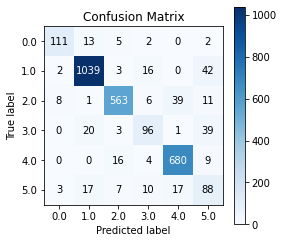

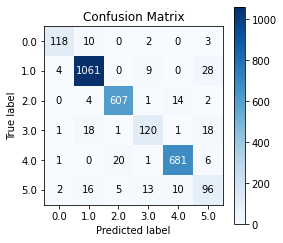

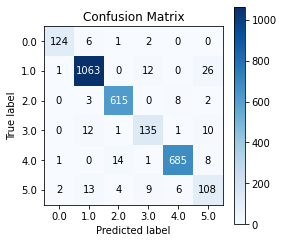

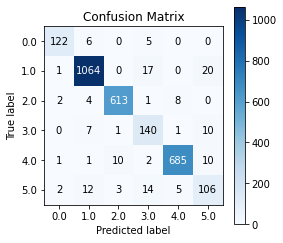

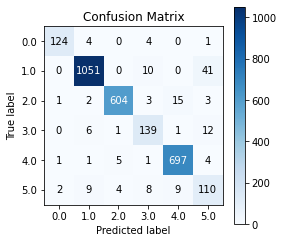

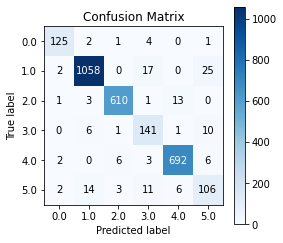

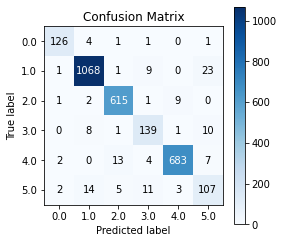

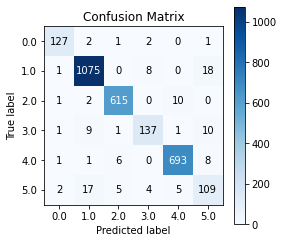

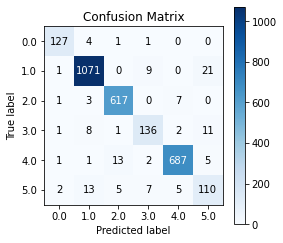

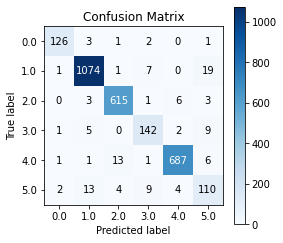

In [86]:
%%time
for it in range(MAXIMUM_INTERATIONS):
    print('*'*5,f' Iteration {it} ','*'*5)
    transform_mean_std =  transforms.Compose([
                                                 transforms.ToPILImage(),
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor()])

    train_dataset   = ImageDataset(os.path.join(SAVE_AL_DATA,f'Dataset_Labeled_{it}.csv'),
                                  le_encoder,
                                  str(BASE_IMG_DIR),
                                  'TRAIN',
                                  image_transform  = transform_mean_std,
                                  label_name       = CLASSIFIER,
                                  target_class_col = 'split_set',
                                  path_col         = 'img_path')
    
    df_ = pd.read_csv(os.path.join(SAVE_AL_DATA,f'Dataset_Labeled_{it}.csv'),sep = '\t')
    shape_train   = df_[df_['split_set']=='TRAIN'].shape[0]
    shape_labeled = df_[(df_['split_set']=='TRAIN')&(df_['Flag_PseudoLabeling']==0)].shape[0]
    shape_pseudo  = df_[(df_['split_set']=='TRAIN')&(df_['Flag_PseudoLabeling']==1)].shape[0]
    del df_
    print(f'Number of Training Samples: {shape_train}')
    mean, std =calc_dataset_mean_std(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    print(f"Mean of the Dataset: {mean}, Std of the Dataset: {std} ")

    # 2.2 Load the DataModule (Train,Val,Test dataloader)
    dm = ImageDataModule( batch_size       = BATCH_SIZE,
                          label_encoder    = le_encoder,
                          data_path        = os.path.join(SAVE_AL_DATA,f'Dataset_Labeled_{it}.csv'),
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [get_train_transf(mean,std),get_valid_transf(mean,std),get_valid_transf(mean,std)],
                          num_workers      = NUM_WORKERS,
                          target_class_col ='split_set',
                          modality_col     = CLASSIFIER,
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()
    
    model = ResNetClass      (name            = RESNET_MODEL,
                                  num_classes     = num_classes,
                                  pretrained      = True,
                                  fine_tuned_from = 'whole',
                                  lr              = LEARNING_RATE,
                                  metric_monitor  = METRIC_MONITOR,
                                  mode_scheduler  = None,
                                  class_weights   = dm.class_weights,
                                  mean_dataset    = mean,
                                  std_dataset     = std)
    
    if (it ==0)|(FLG_RESET == 1):
        a=1
    else:
        print('Loading last model ....')
        checkpoint = torch.load(os.path.join(OUTPUT_DIR,f'higher_modality_v{it-1}.pt'))
        model.load_state_dict(checkpoint['state_dict'])

        
    early_stop_callback = EarlyStopping(
                                        monitor   = METRIC_MONITOR,
                                        min_delta = 0.0,
                                        patience  = 5,
                                        verbose   = True,
                                        mode      = MODE_METRIC)

    checkpoint_callback = ModelCheckpoint(dirpath    = OUTPUT_DIR,
                                          filename   = f'higher_modality_v{it}',
                                          monitor    = METRIC_MONITOR,
                                          mode       = MODE_METRIC,
                                          save_top_k = 1,
                                          save_weights_only = True)
    checkpoint_callback.FILE_EXTENSION = ".pt"
    # 3.3 Setup Trainer
    trainer = Trainer(gpus=1,
                      max_epochs = MAX_EPOCHS,
                      callbacks=[checkpoint_callback,early_stop_callback],
                      deterministic= True,
                      logger = None,
                      num_sanity_val_steps=0)

    trainer.fit(model, dm)
    del model,trainer

    # 3.5 Evaluate on the Test Set (Save Metrics):
    model = ResNetClass.load_from_checkpoint(checkpoint_callback.best_model_path)
    trainer_test = Trainer(gpus=1, logger=None)
    trainer_test.test(model, test_dataloaders=dm.test_dataloader())
    del trainer_test

    # Save Metrics
    df_test = pd.read_csv(os.path.join(SAVE_AL_DATA,f'Dataset_Labeled_{it}.csv'),sep = '\t')
    df_test = df_test[df_test['split_set']=='TEST'].reset_index(drop = True)
    test_dataset = EvalImageDataset (df_test,image_transform=get_valid_transf(mean,std),path_col='img_path',base_img_dir = BASE_IMG_DIR)
    test_dataloader = DataLoader( dataset     = test_dataset,
                                  batch_size  = BATCH_SIZE,
                                  shuffle     = False,
                                  num_workers = NUM_WORKERS)
    
    acc,balanced_acc,macro_f1,macro_recall,macro_precision =run_metrics(le_encoder.transform(df_test.higher_modality),get_prediction(test_dataloader,model,'cuda'))
    

    # Get the idx for uncertainty and pseudo-labeling
    DF_UL_dataset    = EvalImageDataset (DF_UL,image_transform=get_valid_transf(mean,std),path_col='img_path',base_img_dir = BASE_IMG_DIR)
    DF_UL_dataloader = DataLoader(dataset     = DF_UL_dataset,
                                  batch_size  = BATCH_SIZE,
                                  shuffle     = False,
                                  num_workers = NUM_WORKERS)

    DF_UL_PROBS     = get_probs(DF_UL_dataloader,model.to(DEVICE),DEVICE)
    del model
    # Uncertainty: 
    DF_UL['en']   = calc_uncertainty(DF_UL_PROBS,criteria = 'en')
    # Calculate Index Uncertainty
    if CRITERIA == 'en':
        print('Using Entropy')
        DF_UL[CRITERIA]   = calc_uncertainty(DF_UL_PROBS,criteria = CRITERIA)
        idx_unc           = DF_UL.nlargest(SAMPLES,[CRITERIA]).index.to_numpy()     
    elif (CRITERIA =='ms')|(CRITERIA =='lc'):
        print('Using ms/lc')
        DF_UL[CRITERIA]   = calc_uncertainty(DF_UL_PROBS,criteria = CRITERIA)
        idx_unc           = DF_UL.nsmallest(SAMPLES,[CRITERIA]).index.to_numpy()     
    elif CRITERIA == 'rs':
        print('Using rs')
        idx_unc           = np.random.choice(range(len(DF_UL_PROBS)), SAMPLES)
        
    DF_UL_UNCERTAINTY = DF_UL.iloc[idx_unc,:].reset_index(drop = True)
    DF_UL_UNCERTAINTY['Flag_PseudoLabeling'] = 0
    print('Number of Human label samples: ',idx_unc.shape[0])
    # PseudoLabels
    idx_conf             = get_confidence_samples(DF_UL,DELTA)
    print('Number of PseudoLabels: ',len(list(set(idx_conf) - set(idx_unc))))
    if len(list(set(idx_conf) - set(idx_unc)))>0:
        DF_UL_PSEUDOLABELING = DF_UL.iloc[np.array(list(set(idx_conf) - set(idx_unc))),:].reset_index(drop = True)
        DF_UL_PSEUDOLABELING['higher_modality'] = le_encoder.inverse_transform(np.argmax(DF_UL_PROBS, axis=1))[np.array(list(set(idx_conf) - set(idx_unc)))] ## check this
        DF_UL_PSEUDOLABELING['Flag_PseudoLabeling']  = 1
        acc_pseudo = accuracy_score(DF_UL_PSEUDOLABELING['higher_modality'],DF_UL_PSEUDOLABELING['target'])
        print('Acc Pseudo: ' ,acc_pseudo)                   
    else:
        acc_pseudo = None
    
    # save metrics
    df_act = pd.DataFrame({'Sample Method':[CRITERIA],
                           'CEAL':[CEAL],
                           'Iteration':[it],
                           'Labeled (%)':[np.round(100*shape_labeled/10059)],
                          '# Labeled Samples':[shape_labeled],
                          '# Pseudo Samples':[shape_pseudo],
                          'Accuracy':[acc],
                          'Balanced Accuracy':[balanced_acc],
                          'Macro F1-Score':[macro_f1],
                          'Macro Precision':[macro_precision],
                          'Macro Recall':[macro_recall],
                          'Accuracy PseudoLabeling':[acc_pseudo]})
    df_metrics = pd.concat([df_metrics,df_act],axis = 0)
    df_metrics.to_csv(os.path.join(SAVE_AL_DATA,'metrics.csv'),sep = '\t',index = False)
    
    
    # ELiminate from the Unlabeled Dataset
    DF_UL.drop(df.index[list(idx_unc)], inplace=True)
    DF_UL = DF_UL.reset_index(drop = True)

    # New Labeled dataset
    if CEAL :
        print('Using CEAL algorithm')
        DF_NEW = pd.concat([DF_UL_UNCERTAINTY,DF_UL_PSEUDOLABELING],axis = 0).reset_index(drop = True)    
    else:
        DF_NEW = DF_UL_UNCERTAINTY.reset_index(drop = True)
    DF_LABELED = pd.read_csv(os.path.join(SAVE_AL_DATA,f'Dataset_Labeled_{it}.csv'),sep ='\t')
    DF_LABELED = DF_LABELED[DF_LABELED['Flag_PseudoLabeling']==0].reset_index(drop = True)
    DF_LABELED = pd.concat([DF_LABELED,DF_NEW],axis = 0).reset_index(drop = True)
    DF_LABELED.to_csv(os.path.join(SAVE_AL_DATA,f'Dataset_Labeled_{it+1}.csv'),index = False,sep = '\t')

    DELTA = DELTA - DELTA_RATIO
    print(f'DELTA: {DELTA}' )